This notebook will be mainly used for the coursera capstone project

# Bristol Best Location Predictor #

## Background ##

Bristol is a city in the south-west of England with a population of approximately 450,000. I have been living in rented accommodation there for about one and a half years and I'm looking to buy a property. I want to use the machine learning to find the locations within Bristol which are the best value for money and therefore the best places to invest. There are a large amount of factors which contribute to deciding which areas and properties are best for you. Maybe you have a preference for lots of space or perhaps you prefer a built up area with great restaurants and bars to choose from. My project will aim to take some preference inputs from the users and then use the foursquare location data to find areas of Bristol which would be suitable for those people. It will use machine learning to identify how well the areas correlate to the users preferences and then identify the values for money associated with that area. There is a huge amount of scope to create a complicated model with a large number of data inputs and a compex algorithm  to solve this problem. I will start simplistically by taking the data available from foursquare and data on average property prices and using them to build the model.  

## Data ##

Add a description of the data which I am going to use for the project

In [1]:
# This cell imports the libraries which are required for the data gathering and manipulation part of the porject
import pandas as pd # library for data analysis
import numpy as np # library to handle data in a vectorised manner
import json # library to handle json files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests #library ot handle requests
from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library



Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


In [2]:
# The Bristol postcode data comes from wikipedia
Bristol_data = pd.read_html("https://en.wikipedia.org/wiki/BS_postcode_area", header = 0)[1]
Bristol_data.head()

,Postcode district,Post town,Coverage,Local authority area
0,BS0,BRISTOL,Non-geographic[3][4],Bristol
1,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol
2,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol
3,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol
4,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol


There are a number of areas which are defined as "non-geographic" in the coverage column. These are of no interest so shall be removed from the data set

In [3]:
Bristol_data = Bristol_data[~Bristol_data.Coverage.str.contains("Non-geographic")].reset_index()
Bristol_data  = Bristol_data.drop(['index'],axis=1)
Bristol_data

,Postcode district,Post town,Coverage,Local authority area
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol
5,BS6,BRISTOL,"Cotham, Redland, Montpelier, Westbury Park, St...",Bristol
6,BS7,BRISTOL,"Bishopston, Horfield, part of Filton, Lockleaz...",Bristol / South Gloucestershire
7,BS8,BRISTOL,"Clifton, Failand, Hotwells, Leigh Woods",Bristol / North Somerset
8,BS9,BRISTOL,"Coombe Dingle, Sneyd Park, Stoke Bishop, Westb...",Bristol
9,BS10,BRISTOL,"Brentry, Henbury, Southmead, part of Westbury ...",Bristol


We now need to use the post code column information to retreive the latitude and longitude informaiton for each area of Bristol. 

In [4]:
Bristol_data  = Bristol_data.rename(index=str, columns={"Postcode district":'postcode'})
Bristol_data.head()

,postcode,Post town,Coverage,Local authority area
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol


In [5]:
filename = 'https://www.freemaptools.com/download/outcode-postcodes/postcode-outcodes.csv'
df = pd.read_csv(filename, header = 0)
df.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


In [6]:
df = df[df['postcode'].str.match('BS')].reset_index()
df  = df.drop(['index'],axis=1)
df

,id,postcode,latitude,longitude
0,252,BS1,51.453090,-2.593000
1,253,BS10,51.506060,-2.609540
2,254,BS11,51.496720,-2.674250
3,255,BS13,51.411630,-2.611160
4,256,BS14,51.412780,-2.560840
5,257,BS15,51.458900,-2.505270
6,258,BS16,51.484960,-2.509880
7,259,BS2,51.459450,-2.580130
8,260,BS20,51.479160,-2.751760
9,261,BS21,51.434430,-2.848860


We now need to merge the two tables at all instances where they have the same postcode data

In [7]:
result = pd.merge(Bristol_data,df[['latitude','longitude','postcode']],on='postcode')
result.head()

,postcode,Post town,Coverage,Local authority area,latitude,longitude
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.45309,-2.59300
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.45945,-2.58013
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.43776,-2.60144
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.43437,-2.56111
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.46140,-2.54992


Now that we have the latitudes and longitudes of the bristol postcodes we can search for information using the foursquare api. But first we are going to find data which identifies the average property prices in each postcode. To do this we will scrape the data from the zoopla website}, which is a widely used property website in the uk. I should probably find out about the copyright involved in this but that can wait.

In [8]:
postcode = 'bs7'

url = "https://www.zoopla.co.uk/market/{}/?q={}".format(postcode,postcode)
df1 = pd.read_html(url, header = 0)
len(df1)

5

In [9]:
df1[0].head()

,Property type,Avg. current value,Avg. £ per sq ft.,Avg. # beds,Avg. £ paid (last 12m)
0,Detached,"£455,205",£323,3.5,"£470,300"
1,Semi-detached,"£368,277",£324,3.4,"£419,739"
2,Terraced,"£358,263",£352,3.2,"£396,592"
3,Flats,"£241,819",£372,1.8,"£233,954"


The information of interest is the average current value of each property type and the average number of begrooms assocaited with each type. We will now create 8 more columns in the result dataframe to record these values

In [10]:
result['Detached'], result['Detached rooms'],result['Semi-detached'],result['Semi rooms'],result['Terraced'],result['Terraced rooms'],result['Flat'],result['Flat rooms'] = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
result.head()

,postcode,Post town,Coverage,Local authority area,latitude,longitude,Detached,Detached rooms,Semi-detached,Semi rooms,Terraced,Terraced rooms,Flat,Flat rooms
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.45309,-2.59300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.45945,-2.58013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.43776,-2.60144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.43437,-2.56111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.46140,-2.54992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now need to create a loop to cycle through each postcode and add the information for each of the new columns to the dataframe

In [11]:
# Loop through each row of the result database accessing zoopla for each postcode
for row in range(len(result)):
    #specify the url of the zoopla page which contains the pricing information for the current postcode
    url = "https://www.zoopla.co.uk/market/{}/?q={}".format(result['postcode'].iloc[row],result['postcode'].iloc[row])
    print(url)
    # read the information from zoopla into a dataframe
    Ind_Post = pd.read_html(url, header = 0)
    # Add that information to the result dataframe
    result.loc[result.index == row, 'Detached'] = int(Ind_Post[0]['Avg. current value'][0][1:4] + Ind_Post[0]['Avg. current value'][0][5:8]) # Detached
    result.loc[result.index == row, 'Detached rooms'] = Ind_Post[0]['Avg. # beds'][0] # Detached rooms
    result.loc[result.index == row, 'Semi-detached'] = int(Ind_Post[0]['Avg. current value'][1][1:4] + Ind_Post[0]['Avg. current value'][1][5:8]) # Semi
    result.loc[result.index == row, 'Semi rooms'] = Ind_Post[0]['Avg. # beds'][1] # Semi rooms
    result.loc[result.index == row, 'Terraced'] = int(Ind_Post[0]['Avg. current value'][2][1:4] + Ind_Post[0]['Avg. current value'][2][5:8]) # Terraced
    result.loc[result.index == row, 'Terraced rooms'] = Ind_Post[0]['Avg. # beds'][2] # Terraced rooms
    result.loc[result.index == row, 'Flat'] = int(Ind_Post[0]['Avg. current value'][3][1:4] +Ind_Post[0]['Avg. current value'][3][5:8]) # Flat
    result.loc[result.index == row, 'Flat rooms'] = Ind_Post[0]['Avg. # beds'][3]# Flat rooms
    print('Postcode ' + result['postcode'].iloc[row] + ' entered')

https://www.zoopla.co.uk/market/BS1/?q=BS1
Postcode BS1 entered
https://www.zoopla.co.uk/market/BS2/?q=BS2
Postcode BS2 entered
https://www.zoopla.co.uk/market/BS3/?q=BS3
Postcode BS3 entered
https://www.zoopla.co.uk/market/BS4/?q=BS4
Postcode BS4 entered
https://www.zoopla.co.uk/market/BS5/?q=BS5
Postcode BS5 entered
https://www.zoopla.co.uk/market/BS6/?q=BS6
Postcode BS6 entered
https://www.zoopla.co.uk/market/BS7/?q=BS7
Postcode BS7 entered
https://www.zoopla.co.uk/market/BS8/?q=BS8
Postcode BS8 entered
https://www.zoopla.co.uk/market/BS9/?q=BS9
Postcode BS9 entered
https://www.zoopla.co.uk/market/BS10/?q=BS10
Postcode BS10 entered
https://www.zoopla.co.uk/market/BS11/?q=BS11
Postcode BS11 entered
https://www.zoopla.co.uk/market/BS13/?q=BS13
Postcode BS13 entered
https://www.zoopla.co.uk/market/BS14/?q=BS14
Postcode BS14 entered
https://www.zoopla.co.uk/market/BS15/?q=BS15
Postcode BS15 entered
https://www.zoopla.co.uk/market/BS16/?q=BS16
Postcode BS16 entered
https://www.zoopla.co.

In [12]:
result.head()

,postcode,Post town,Coverage,Local authority area,latitude,longitude,Detached,Detached rooms,Semi-detached,Semi rooms,Terraced,Terraced rooms,Flat,Flat rooms
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.45309,-2.59300,578579.0,3.2,465149.0,3.5,559642.0,3.6,297263.0,1.7
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.45945,-2.58013,484784.0,4.0,378413.0,3.3,313432.0,2.9,214309.0,1.7
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.43776,-2.60144,403347.0,3.0,326094.0,3.1,329666.0,2.8,219092.0,1.6
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.43437,-2.56111,370937.0,3.5,250609.0,3.1,261435.0,2.9,184128.0,1.6
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.46140,-2.54992,339367.0,3.3,263151.0,3.0,237962.0,2.7,163339.0,1.7


In [13]:
# create map of Bristol using latitude and longitude values
map_bristol = folium.Map(location=[result['latitude'][0], result['longitude'][0]], zoom_start=10)

# add markers to map
for lat, lng, LocAuth, Cov in zip(result['latitude'], result['longitude'], result['Local authority area'], result['Coverage']):
    label = '{}, {}'.format(LocAuth, Cov)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bristol)  
    
map_bristol

Get foursquare user information

In [14]:
CLIENT_ID = 'OSW1KTQUNE51USGICIN5BL4XHCSS435UX12U1PO4354KJSPS' # your Foursquare ID
CLIENT_SECRET = 'XU4ZU12KCZSHPLIGLOHLWX0OSUZNK2VYIMQSGDCAITJYTNPS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OSW1KTQUNE51USGICIN5BL4XHCSS435UX12U1PO4354KJSPS
CLIENT_SECRET:XU4ZU12KCZSHPLIGLOHLWX0OSUZNK2VYIMQSGDCAITJYTNPS


In [15]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 1000 # define radius

longitude = result['longitude'][0]

latitude = result['latitude'][0]

section = 'food'

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius,
    section,
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=OSW1KTQUNE51USGICIN5BL4XHCSS435UX12U1PO4354KJSPS&client_secret=XU4ZU12KCZSHPLIGLOHLWX0OSUZNK2VYIMQSGDCAITJYTNPS&v=20180605&ll=51.45309,-2.593&radius=1000&query=food&limit=100'

Create a function to get information for nearby venues

In [16]:
def get_nearby_venues(latitude,longitude):
    # section = 'food'
    # latitude = 51.45309
    # longitude = -2.593
    radius = 1000
    LIMIT = 10000
    venues_list=[]

    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT
    )
       
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']    
    venues_list.append([(
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])
    # venues_list
    if venues_list != [[]]:
        nearby_venues_local = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues_local.columns = [ 
                          'Venue', 
                          'Venue Category']  
        # print(nearby_venues_local.shape)
        return(nearby_venues_local)
    else: 
        nearby_venues_local = pd.DataFrame(columns=['Venue','Venue Category'])
        return(nearby_venues_local)

In [17]:
nearby_venues = pd.DataFrame(columns=['Venue','Venue Category','postcode'])
result['no. venues'] = 0
df1 = pd.DataFrame_columns=['postcode','no. venues']
for row in range(len(result)):
    print(row)
    postcode = result.iloc[row]['postcode']
    print(postcode)
    lat = result.iloc[row]['latitude']

    long = result.iloc[row]['longitude']
   
    a = get_nearby_venues(lat,long)
    # print(a)
    a['postcode'] = postcode
    result.at[row,'no. venues'] = len(a)
    nearby_venues = nearby_venues.append(a,ignore_index=True)
    print(nearby_venues.shape)
nearby_venues.head()



0
BS1
(100, 3)
1
BS2
(196, 3)
2
BS3
(249, 3)
3
BS4
(258, 3)
4
BS5
(273, 3)
5
BS6
(367, 3)
6
BS7
(394, 3)
7
BS8
(494, 3)
8
BS9
(514, 3)
9
BS10
(521, 3)
10
BS11
(528, 3)
11
BS13
(544, 3)
12
BS14
(549, 3)
13
BS15
(560, 3)
14
BS16
(577, 3)
15
BS20
(581, 3)
16
BS21
(587, 3)
17
BS22
(592, 3)
18
BS23
(638, 3)
19
BS24
(642, 3)
20
BS25
(648, 3)
21
BS26
(652, 3)
22
BS27
(662, 3)
23
BS28
(670, 3)
24
BS29
(676, 3)
25
BS30
(684, 3)
26
BS31
(697, 3)
27
BS32
(715, 3)
28
BS34
(730, 3)
29
BS35
(733, 3)
30
BS36
(739, 3)
31
BS37
(766, 3)
32
BS39
(768, 3)
33
BS40
(768, 3)
34
BS41
(770, 3)
35
BS48
(774, 3)
36
BS49
(783, 3)


,Venue,Venue Category,postcode
0,Small Bar,Pub,BS1
1,Small Street Espresso,Coffee Shop,BS1
2,BrewDog Bristol,Beer Bar,BS1
3,St. Nicholas Market,Market,BS1
4,Bristol Old Vic,Theater,BS1


In [18]:
nearby_venues.tail()

,Venue,Venue Category,postcode
778,Marco Pierre White Steakhouse Bar & Grill,Steakhouse,BS49
779,Tesco,Grocery Store,BS49
780,Cohens Chemist,Pharmacy,BS49
781,LHS,Construction & Landscaping,BS49
782,Terrace Cafe,Coffee Shop,BS49


In [19]:
result.head()

,postcode,Post town,Coverage,Local authority area,latitude,longitude,Detached,Detached rooms,Semi-detached,Semi rooms,Terraced,Terraced rooms,Flat,Flat rooms,no. venues
0,BS1,BRISTOL,"Bristol city centre, Redcliffe",Bristol,51.45309,-2.59300,578579.0,3.2,465149.0,3.5,559642.0,3.6,297263.0,1.7,100
1,BS2,BRISTOL,"Kingsdown, St Paul's, St Phillip's, St Agnes",Bristol,51.45945,-2.58013,484784.0,4.0,378413.0,3.3,313432.0,2.9,214309.0,1.7,96
2,BS3,BRISTOL,"Bedminster, Southville, Bower Ashton, part of ...",Bristol,51.43776,-2.60144,403347.0,3.0,326094.0,3.1,329666.0,2.8,219092.0,1.6,53
3,BS4,BRISTOL,"Brislington, Knowle, Knowle West, St Anne's, p...",Bristol,51.43437,-2.56111,370937.0,3.5,250609.0,3.1,261435.0,2.9,184128.0,1.6,9
4,BS5,BRISTOL,"Easton, St George, Redfield, Whitehall, Eastvi...",Bristol,51.46140,-2.54992,339367.0,3.3,263151.0,3.0,237962.0,2.7,163339.0,1.7,15


Now that the data has been wrangled into shape I am going to plot the corelation between house prices and the number of nearby venues.

I will be using linear and non-linear regression on each type of property. I will train using the whole data set as out of sample accuracy is not important. Each type of regression will be evaluated using the relevant metrics and conclusions will be drawn.

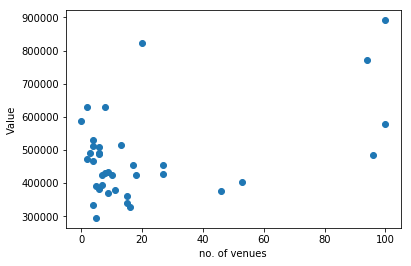

The correlation is  0.45736412565
The p_value is  0.00442687809466


In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
x = result['no. venues']
y = result['Detached']
plt.scatter(x,y)
plt.ylabel('Value')
plt.xlabel('no. of venues')
plt.show()


from scipy.stats import pearsonr
corr, p_value = pearsonr(x, y)
print('The correlation is ',  corr)
print('The p_value is ',  p_value)

In [36]:
df_detached = result[['Detached','no. venues']]

import numpy as np
msk = np.random.rand(len(result)) < 0.8
train = df_detached[msk]
test = df_detached[~msk]

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['no. venues']])
train_y = np.asanyarray(train[['Detached']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 2222.64420466]]
Intercept:  [ 439726.99770482]


Text(0,0.5,'Detached Price')

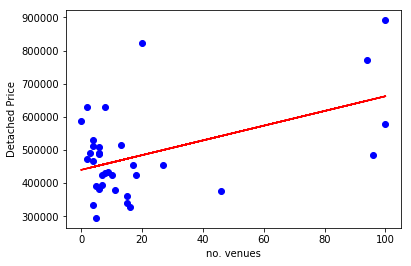

In [38]:
x = train['no. venues']
y = train['Detached']
plt.scatter(x,y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("no. venues")
plt.ylabel("Detached Price")

In [39]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['no. venues']])
test_y = np.asanyarray(test[['Detached']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 104638.11
Residual sum of squares (MSE): 12229464325.40
R2-score: -6.59


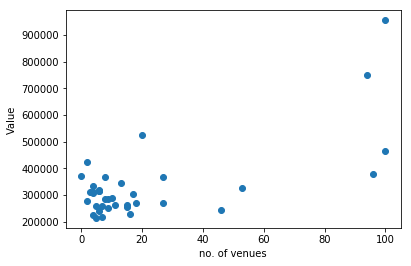

The correlation is  0.689402637777
The p_value is  2.37120806334e-06


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
x = result['no. venues']
y = result['Semi-detached']
plt.scatter(x,y)
plt.ylabel('Value')
plt.xlabel('no. of venues')
plt.show()

corr, p_value = pearsonr(x, y)
print('The correlation is ',  corr)
print('The p_value is ',  p_value)

In [40]:
df_detached = result[['Semi-detached','no. venues']]

import numpy as np
msk = np.random.rand(len(result)) < 0.8
train = df_detached[msk]
test = df_detached[~msk]

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['no. venues']])
train_y = np.asanyarray(train[['Semi-detached']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 3681.50096299]]
Intercept:  [ 251072.5752467]


Text(0,0.5,'Semi-detached Price')

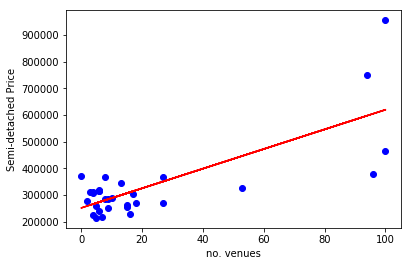

In [41]:
x = train['no. venues']
y = train['Semi-detached']
plt.scatter(x,y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("no. venues")
plt.ylabel("Semi-detached Price")

In [42]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['no. venues']])
test_y = np.asanyarray(test[['Semi-detached']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 108898.34
Residual sum of squares (MSE): 17265952136.37
R2-score: -4.64


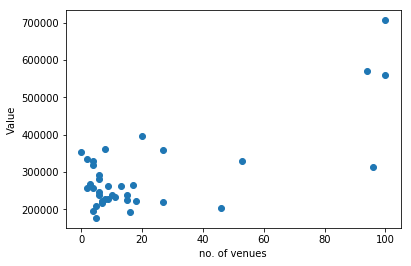

The correlation is  0.72983021199
The p_value is  2.96830801081e-07


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
x = result['no. venues']
y = result['Terraced']
plt.scatter(x,y)
plt.ylabel('Value')
plt.xlabel('no. of venues')
plt.show()

corr, p_value = pearsonr(x, y)
print('The correlation is ',  corr)
print('The p_value is ',  p_value)

In [43]:
df_detached = result[['Terraced','no. venues']]

import numpy as np
msk = np.random.rand(len(result)) < 0.8
train = df_detached[msk]
test = df_detached[~msk]

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['no. venues']])
train_y = np.asanyarray(train[['Terraced']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 2635.85697103]]
Intercept:  [ 232525.61957333]


Text(0,0.5,'Terraced Price')

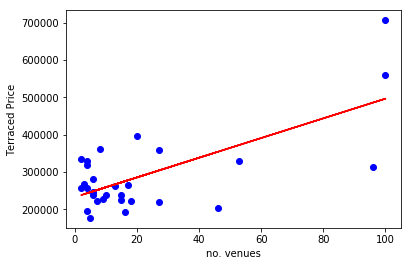

In [44]:
x = train['no. venues']
y = train['Terraced']
plt.scatter(x,y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("no. venues")
plt.ylabel("Terraced Price")

In [45]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['no. venues']])
test_y = np.asanyarray(test[['Terraced']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 47791.27
Residual sum of squares (MSE): 3516122870.41
R2-score: 0.40


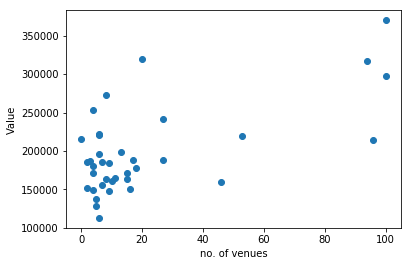

The correlation is  0.632774304233
The p_value is  2.64206361432e-05


In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
x = result['no. venues']
y = result['Flat']
plt.scatter(x,y)
plt.ylabel('Value')
plt.xlabel('no. of venues')
plt.show()

corr, p_value = pearsonr(x, y)
print('The correlation is ',  corr)
print('The p_value is ',  p_value)

In [47]:
df_detached = result[['Flat','no. venues']]

import numpy as np
msk = np.random.rand(len(result)) < 0.8
train = df_detached[msk]
test = df_detached[~msk]

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['no. venues']])
train_y = np.asanyarray(train[['Flat']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[ 1137.42263004]]
Intercept:  [ 180306.77512566]


Text(0,0.5,'Flat Price')

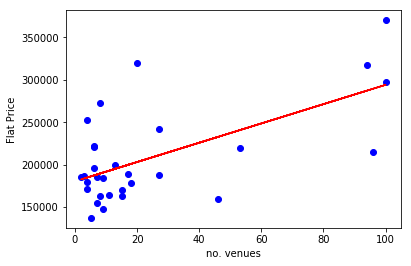

In [48]:
x = train['no. venues']
y = train['Flat']
plt.scatter(x,y,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("no. venues")
plt.ylabel("Flat Price")

In [50]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['no. venues']])
test_y = np.asanyarray(test[['Flat']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 44784.29
Residual sum of squares (MSE): 2238901801.02
R2-score: -69.08


In [ ]:
1 + 1